# Transformada rápida de Fourier (FFT)

<div class="alert alert-block alert-warning">
Este notebook es parte de una colección de apuntes para el curso IEE2103 Señales y Sistemas, <a href="http://https://www.ing.uc.cl/electrica/">Departamento de Ingeniería Eléctrica</a>, <a href="http://www.uc.cl">Pontificia Universidad Católica de Chile</a>.<br> Profesor: <a href="http://www.rodrigocadiz.com">Rodrigo F. Cádiz</a><br>
Consultas y comentarios: <a href="mailto:rcadiz@ing.puc.cl">rcadiz@ing.puc.cl</a>

</div>

***

## Fast Fourier Transform

The discrete Fourier transformation (DFT) can be implemented computationally very efficiently by the [fast Fourier transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). Various algorithms have been developed for the FFT resulting in various levels of computational efficiency for a wide range of DFT lengths. The concept of the so called [radix-2 Cooley–Tukey algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) is introduced in the following as representative.

## Transformada rápida de Fourier

La transformada discreta de Fourier (DFT) puede implementarse computacionalmente de manera muy eficiente mediante la [transformada rápida de Fourier (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). Existen varios algoritmos para la FFT que difieren en sus grados de eficiencia. El algoritmo más conocido se denomina el [algoritmo de Cooley-Tukey](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm). La forma más simple de este algoritmo también se conoce como decimación en el tiempo radix-2.

### Algoritmo de decimación en el tiempo (Radix-2)

Consideremos la definición de la DFT $\tilde{F}[k] = \text{DFT}_N \{ \tilde{f}[n] \}$:

\begin{equation}
\tilde{F}[k] = \frac{1}{N}\sum_{n=0}^{N-1} \tilde{f}[n] \, w_N^{kn}
\end{equation}

donde $w_N$ denota la base de Fourier $e^{-i \frac{2 \pi}{N}}$. La evaluación de la definición para $k = 0,1,\dots,N-1$ requiere $N^2$ multiplicaciones y $N \cdot (N-1)$ sumas. La complejidad numérica de la DFT es de [orden](https://en.wikipedia.org/wiki/Big_O_notation) $\mathcal{O} (N^2)$.

La idea básica del algoritmo de decimación en el tiempo de la FFT es descomponer el cálculo de la DFT en dos sumas: una sobre los índices pares $n$ de la señal $\tilde{f}[n]$ y otra sobre los índices impares. Reorganizando los términos podemos escribir:


\begin{equation}
\tilde{F}[k] = \frac{1}{N}\left(\underbrace{\sum_{m = 0}^{\frac{N}{2} - 1} \tilde{f}[2 m] \, w_N^{k 2m}}_{\tilde{F}_e[k] =\text{DFT de elementos pares}} + 
\underbrace{\sum_{m = 0}^{\frac{N}{2} - 1} \tilde{f}[2 m + 1] \, w_N^{k (2 m + 1)}}_{\tilde{F}_o[k] = \text{DFT de elementos impares}} \right)
\end{equation}

Notando la exponencial adicional que aparece en el lado derecho, podemos escribir esto mismo de forma más suscinta:

\begin{equation}
\tilde{F}[k] = \frac{1}{N} \left(\tilde{F}_e[k] + w_N^{k} \cdot \tilde{F}_o[k] \right)
\end{equation}

donde $\tilde{F}_e[k]$ es la DFT de largo $N/2$ de las muestras pares y $\tilde{F}_o[k]$ es la DFT de largo $N/2$ de las muestras impares. Esta forma de la DFT requiere $2 \cdot (\frac{N}{2})^2 + N$ multiplicaciones y $2 \cdot \frac{N}{2} \cdot (\frac{N}{2} -1) + N$ sumas, lo que implica una eficiencia mayor que la forma matricial. 

En general, para un largo $N = 2^w$ con $w \in \mathbb{N}$, potencia de dos, este principio puede aplicarse de forma recursiva hasta que se alcancen DFTs de longitud $2$. Es por esto que este algoritmo se conoce también como radix-2. 
En el caso general se requieren $\frac{N}{2} \log_2 N$ multiplicaciones y $N \log_2 N$ sumas. La complejidad numérica del algoritmo FFT es, entonces, de orden $\mathcal{O} (N \log_2 N)$. La denominación decimación en el tiempo se debe al hecho de que la descomposición se realiza con respecto a la señal $f[n]$ en el dominio del tiempo y no a su espectro $F[k]$.

Para el caso $N=16$ se ilustra este algoritmo mediante un diagrama donde se muestran los índices de la señal y el reordenamiento que sufren a medida que el algoritmo avanza. 
![Algoritmo aplicado a una señal de largo $N=16$](images/FFT1.png)

Al final del proceso, obtenemos señales de largo $N=2$, para las cuales el cálculo de la DFT es trivial dado que es simplemente la suma y la resta de las muestras de la señal dividido por dos.

***
### Pruebas de tiempo de cálculo

El algoritmo DIT radix-2 presentado anteriormente solo se puede aplicar en secuencias de largo potencias de dos $N = 2^w$. Sin embargo, es posible aplicar principios similares y otras técnicas para implementar algoritmos eficientes para otros casos.

A continuación compararemos el rendimiento de la función [`numpy.fft`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html#numpy.fft.fft) de `numpy`, que implementa el aloritmo radix-2 de la FFT con el tiempo de ejecución de una DFT calculada mediante su [formulación matricial](./34-DFT.ipynb#representacion_matricial).

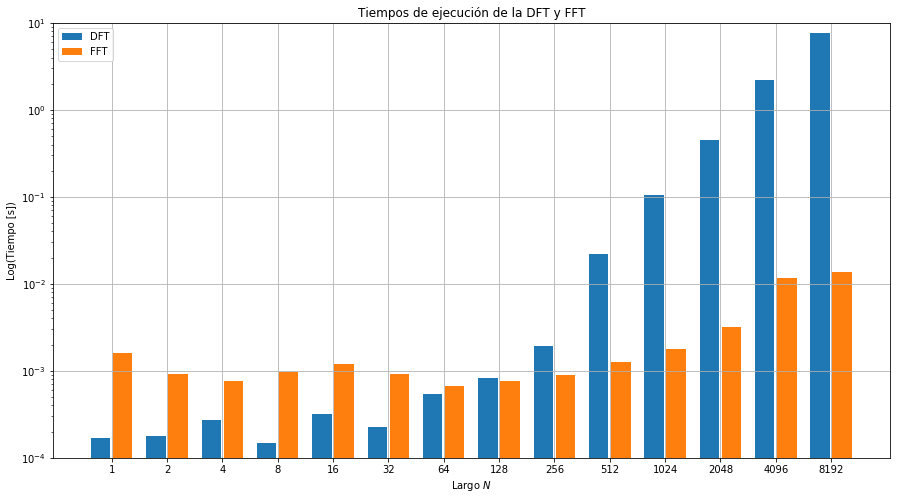

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import timeit
%matplotlib inline

n = np.arange(14)  # lengths = 2**n to evaluate
reps = 100  # number of repetitions per measurement

# measure execution times
timesc = np.zeros(len(n))
timesf = np.zeros(len(n))

for N in n:
    length = 2**N
    # setup environment for timeit
    tsetup = 'import numpy as np; from scipy.linalg import dft;  \
            f=np.random.randn(%d)+1j*np.random.randn(%d); F = dft(%d)' % (length, length, length)
    # DFT
    tc = timeit.timeit('np.matmul(F, f)', setup=tsetup, number=reps)
    # FFT
    tf = timeit.timeit('np.fft.fft(f)', setup=tsetup, number=reps)
    # gain by using the FFT
    timesc[N] = tc
    timesf[N] = tf

plt.figure(figsize=(15,8))
plt.bar(n-0.2, timesc, 0.35, log=True, label='DFT')
plt.bar(n+0.2, timesf, 0.35, log=True, label='FFT')
plt.xticks(n, 2**n)
plt.title('Tiempos de ejecución de la DFT y FFT')
plt.ylim(0.0001,10)
plt.xlabel('Largo $N$')
plt.ylabel('Log(Tiempo [s])')
plt.legend()
plt.grid()

plt.show()

<div class="alert alert-block alert-warning">
<b>Copyright</b><br>

Estos apuntes están licenciados bajo la licencia <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0</a>.<br>
Como citar: <i>Rodrigo F. Cádiz, Apuntes de Señales y Sistemas.</i>
</div>